# NLP on two companies from twitter posts.
#### This project is an approach to apply Natural Language Processing on twitter posts to get insight of the topics that interest the most people, public opinion and sentiment analysis about two different companies in the same sector. "Electric Vehicles"

### Importing Libraries.

In [104]:
# Pandas: This library will used to create and work with dataframes.
import pandas as pd 
# Matplotlib: Used to plot graphics. 
import matplotlib.pyplot as plt
# Seaborn: Used to better style and improve graphics. 
import seaborn as sns
# Numpy for mathematic calculations. 
import numpy as np
#Tweepy: Used to work with the Twitter API.
import tweepy as tw
#ConfigParser: Used to get credentials for the twitter API.
import configparser as cp
#NLTK its used to pre-proccess text and regex its used to filter that text.
import nltk, re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
custom_stopwords = ["Tesla", "tesla", "TSLA", "tsla", "Rivian", "rivian", "RIVN", "rivn"]
normalizer = WordNetLemmatizer()
#Library to count words
from collections import Counter
# library to build wordclouds
from wordcloud import WordCloud
# NLTK to analice sentiment. 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
#Another Library to perform sentiment analisis.
from textblob import Word, TextBlob
net = Network(notebook=True)
# NLTK library to build ngrams.
from nltk.util import ngrams
# NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
import networkx as nx
from pyvis.network import Network
# Built on top of plotly.js, plotly.py is a high-level, declarative charting library.
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing and authenticating API credentials from the config file. 

In [84]:
config =  cp.ConfigParser()
config.read("config.ini")

api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

# Authentication

auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

### Funtions to work with in this project.

In [110]:
# Function to perform data extraction from twitter.
def scrape(words, numtweet):
# We are using .Cursor() to search
# through twitter for the required tweets.
# The number of tweets can be
# restricted using .items(number of tweets)
    tweets = tw.Cursor(api.search_tweets,
                               words, 
                               lang="en",
                               tweet_mode='extended').items(numtweet)


# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes
# that you can access to
# get information about each tweet
    list_tweets = [tweet for tweet in tweets]
 
# we will iterate over each tweet in the
# list for extracting information about each tweet
    columns=['tweet_date','tweets']
    data = []
    for tweet in list_tweets:
        tweet_date = tweet.created_at
# Retweets can be distinguished by
# a retweeted_status attribute,
# in case it is an invalid reference,
# except block will be executed
        try:
            tweets = tweet.retweeted_status.full_text
        except AttributeError:
            tweets = tweet.full_text
            data.append([tweet_date, tweets])
# Creating DataFrame using pandas
    df = pd.DataFrame(data, columns=columns)
    print(words + " Data.")
    return df 

#Functions to preproccess text.
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

def preprocess_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if token not in stop_words]
  normalized = [token for token in normalized if token not in custom_stopword]
  return normalized

# Cleaning text. 
def clean_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  cleaned = " ".join(word for word in cleaned.split() if word not in stop_words)
  cleaned = " ".join(word for word in cleaned.split() if word not in custom_stopwords)
  cleaned = " ".join(normalizer.lemmatize(word, get_part_of_speech(word)) for word in cleaned.split())
  return cleaned

# Function to build and plot a WordCloud.
def wordcloud(str1, str2):
    wordcloud1 = WordCloud (
                    background_color = 'white',
                    width = 620,
                    height = 410
                        ).generate(' '.join(str1))
    wordcloud2 = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(str2))
#plot the wordcloud object
    plt.figure(figsize = (18,14))
    plt.subplot(1,2,1)
    plt.title("Ford WordCloud")
    plt.imshow(wordcloud1, interpolation='bilInear')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Tesla WordCloud")
    plt.imshow(wordcloud2, interpolation='bilInear')
    plt.axis('off')
    plt.show()

#Sentiment finder
def sentiment(text):
    score = sia.polarity_scores(text)
    pos = score["pos"]
    neg = score["neg"]
    if pos > neg:
        sentiment = "positive"
    elif neg > pos:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment


### Getting the data from twitter.

In [111]:
tesla = scrape("TSLA", 100)
rivian = scrape("RIVN", 100)

TSLA Data.
RIVN Data.


### Preproccessing the data for further analisys.

In [87]:
tesla_preprocess = preprocess_text("".join(tesla.tweets), custom_stopwords)
rivian_preprocess = preprocess_text("".join(rivian.tweets), custom_stopwords)

### Counting words with bag of words

In [88]:
tesla_bow = Counter(tesla_preprocess)
rivian_bow = Counter(rivian_preprocess)

print("\nThen most frequent words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla = tesla_bow.most_common(10)
print(most_common_tesla)
print("\nTen most frequent words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian = rivian_bow.most_common(10)
print(most_common_rivian)


Then most frequent words and number of occurrences for Tesla according to Bag-of-Words:
[('get', 10), ('stock', 8), ('elonmusk', 8), ('5', 8), ('1', 8), ('2', 7), ('gt', 7), ('3', 6), ('4', 6), ('buy', 6)]

Ten most frequent words and number of occurrences for Rivian according to Bag-of-Words:
[('nio', 16), ('lcid', 14), ('9', 14), ('1', 13), ('stock', 13), ('amc', 13), ('5', 13), ('6', 11), ('gme', 10), ('7', 10)]


### Building a WordCloud

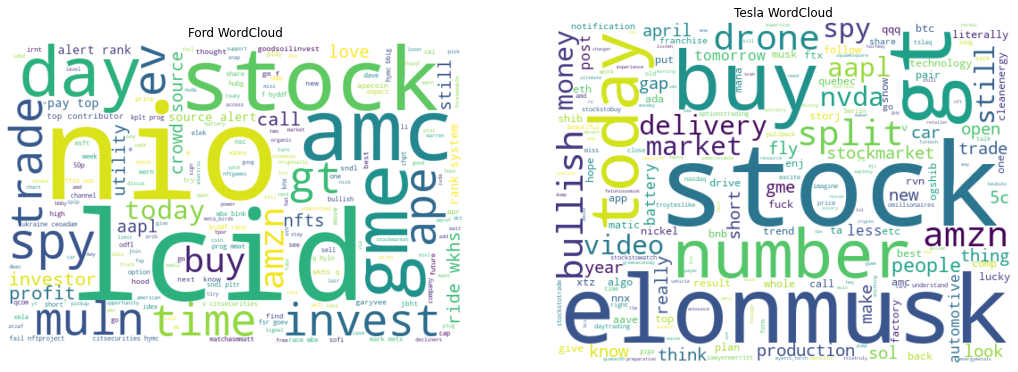

In [109]:
wordcloud(rivian_preprocess, tesla_preprocess)

### Finding the sentiment of each tweet using nltk SentimentIntensityAnalyzer

In [90]:
# In this case we just need to clean the data and create a new column with it.
tesla["clean_tweet"] = tesla["tweets"].apply(lambda x: clean_text(x, custom_stopwords))
rivian["clean_tweet"] = rivian["tweets"].apply(lambda x: clean_text(x, custom_stopwords))
# Now we can apply the sentiment function and create a new column with it.
tesla["sentiment"] = tesla["clean_tweet"].apply(sentiment)
rivian["sentiment"] = rivian["clean_tweet"].apply(sentiment)
rivian.head()


,tweet_date,tweets,clean_tweet,sentiment
0,2022-04-01 21:11:42+00:00,Would you consider buying $AMZN when the 20-1 ...,would consider buy amzn 20 1 stock split happe...,neutral
1,2022-04-01 21:10:19+00:00,$XELA Outlook ⬆️\n\nOther stocks 2022\n$BBIG $...,xela outlook stock 2022 bbig amc gme cei kplt ...,neutral
2,2022-04-01 21:09:03+00:00,@EmmetPeppers @goodsoilinvest @MatchasmMatt “I...,emmetpeppers goodsoilinvest matchasmmatt inves...,negative
3,2022-04-01 21:00:07+00:00,"📉 Today's Top 10 Loser #Stocks 📉\nFri, Apr 01,...",today top 10 loser stock fri apr 01 2022 04 00...,negative
4,2022-04-01 20:55:16+00:00,@qcapital2020 Would love to have you on our @g...,qcapital2020 would love goodsoilinvest yt chan...,positive


### Sentiment count per company.

In [91]:
# Total sentiment count
sentiment_count_tesla =  tesla.groupby('sentiment')['sentiment'].count()
sentiment_count_rivian = rivian.groupby('sentiment')['sentiment'].count()
#Creating a df with that count to plot later. 
total_sentiments_tesla = sentiment_count_tesla.to_frame()
total_sentiments_tesla.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_tesla.reset_index(inplace=True)

total_sentiments_rivian = sentiment_count_rivian.to_frame()
total_sentiments_rivian.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_rivian.reset_index(inplace=True)

print("Total sentiment count of Ford:")
print(total_sentiments_rivian)
print("\nTotal sentiment count of Tesla: ")
print(total_sentiments_tesla)

# Sentiment count by day
day_tesla_sentiment_count = tesla.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
day_rivian_sentiment_count = rivian.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
#day_tesla_sentiment_count

Total sentiment count of Ford:
  sentiment  count
0  negative     14
1   neutral     24
2  positive     43

Total sentiment count of Tesla: 
  sentiment  count
0  negative     15
1   neutral     17
2  positive     22


### Sentiments BarCharts

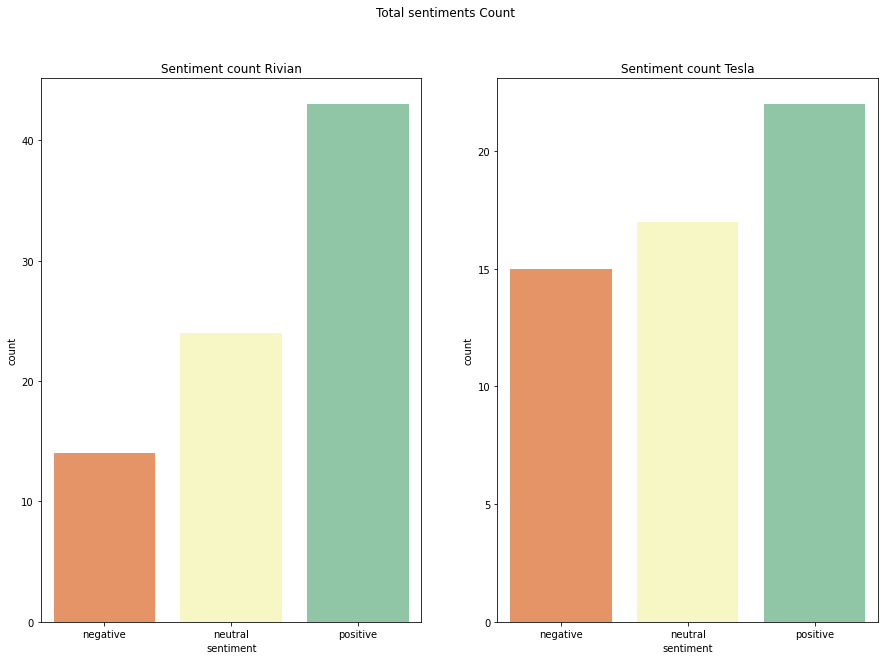

<Figure size 432x288 with 0 Axes>

In [92]:
#Plot with matplotlib

plt.figure(figsize=(15,10))
plt.suptitle("Total sentiments Count")
plt.subplot(1,2,1)
plt.title("Sentiment count Rivian")
sns.barplot(x="sentiment", y="count", data=total_sentiments_rivian, palette="Spectral")
plt.subplot(1,2,2)
plt.title("Sentiment count Tesla")
sns.barplot(x="sentiment", y="count", data=total_sentiments_tesla, palette="Spectral")
plt.show()
plt.clf()

# Plot with Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=("Tesla", "Rivian"))

fig.add_trace(
    go.Bar(x=total_sentiments_tesla["sentiment"], y=total_sentiments_tesla["count"], marker_color=("#de425b", "#9fc08f", "#488f31")),
    row=1, col=2)
fig.update_xaxes(title_text="Sentiment")
fig.update_yaxes(title_text="Count")
fig.update_layout(height=800, width=1000, title_text="Total sentiments Counts", showlegend=False)
fig.add_trace(
    go.Bar(x=total_sentiments_rivian["sentiment"], y=total_sentiments_rivian["count"], marker_color=("#de425b", "#9fc08f", "#488f31")),
    row=1, col=1)
fig.show()



### Finding the sentiment of each tweet using TextBlob
##### Polarity: range from -1 to 1, being -1 the most negative sentiment and 1 the most positive.
##### Subjectivity: quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [93]:
tesla["polarity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
tesla["subjectivity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
rivian["polarity"] = rivian["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
rivian["subjectivity"] = rivian["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
tesla.head()

,tweet_date,tweets,clean_tweet,sentiment,polarity,subjectivity
0,2022-04-01 21:21:13+00:00,@Tesla $tsla so you guys think Tesla tomorrow ...,guy think tomorrow post anything less halfway ...,positive,0.000000,0.366667
1,2022-04-01 21:21:02+00:00,"@elonmusk hey Elon, $tsla, with all your exper...",elonmusk hey elon expertise experience think m...,neutral,0.000000,0.000000
2,2022-04-01 21:20:57+00:00,Had a plan for the market today and literally ...,plan market today literally opposite gotta fol...,neutral,-0.083333,0.033333
3,2022-04-01 21:20:44+00:00,@FeloniousMusk @Wyatts_Torch @Keubiko No one c...,feloniousmusk wyatts_torch keubiko one call no...,negative,-0.083333,0.416667
4,2022-04-01 21:20:11+00:00,This is possibly one of the best drone footage...,possibly one best drone footage ever see wow h...,positive,0.366667,0.766667


### Mean and Median of Polarity and subjectivity by brand.

In [94]:
print("Tesla")
display(tesla[["polarity", "subjectivity"]].agg([np.mean, np.median]))
print("Rivian")
rivian[["polarity", "subjectivity"]].agg([np.mean, np.median])

Tesla


,polarity,subjectivity
mean,0.070711,0.373694
median,0.000000,0.400000


Rivian


,polarity,subjectivity
mean,0.108496,0.344658
median,0.000000,0.346970


### Visualizing the moving average of the sentiments.

In [95]:
# Building dataframes for the visualization. 
tesla_ma = tesla[["tweet_date", "polarity"]]
tesla_ma = tesla_ma.sort_values(by="tweet_date", ascending=True)
tesla_ma["MA Polarity"] = tesla_ma.polarity.rolling(10, min_periods=3).mean()

rivian_ma = rivian[["tweet_date", "polarity"]]
rivian_ma = rivian_ma.sort_values(by="tweet_date", ascending=True)
rivian_ma["MA Polarity"] = rivian_ma.polarity.rolling(10, min_periods=3).mean()


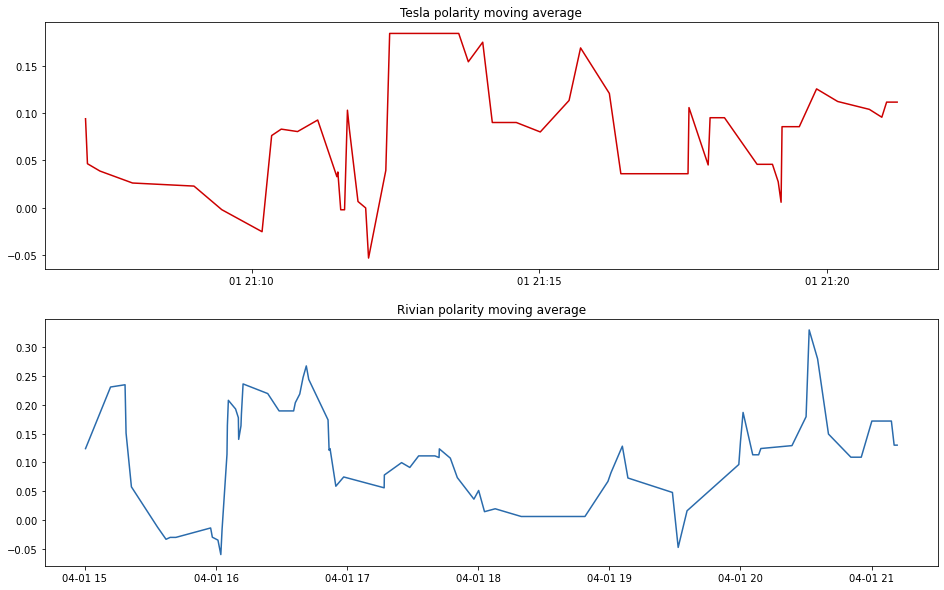

<Figure size 432x288 with 0 Axes>

In [96]:
#Plotting both graph with matplotib. 

fig, ax = plt.subplots(2, 1, figsize=(16,10))
ax[0].plot(tesla_ma["tweet_date"], tesla_ma["MA Polarity"], color="#cc0000")
ax[0].set_title("Tesla polarity moving average")

ax[1].plot(rivian_ma["tweet_date"], rivian_ma["MA Polarity"], color="#2A6BAC")
ax[1].set_title("Rivian polarity moving average")

plt.show()
plt.clf()

#Plotting both graph with Plotly. 


fig1 = px.line(tesla_ma, x="tweet_date", y="MA Polarity", title="Tesla polarity moving average")
fig1.update_traces(line_color='#cc0000')
fig1.show()
fig2 = px.line(rivian_ma, x="tweet_date", y="MA Polarity", title="Rivian polarity moving average")
fig2.update_traces(line_color='#2A6BAC')
fig2.show()

### Visualizing Subjectivity and Polarity 

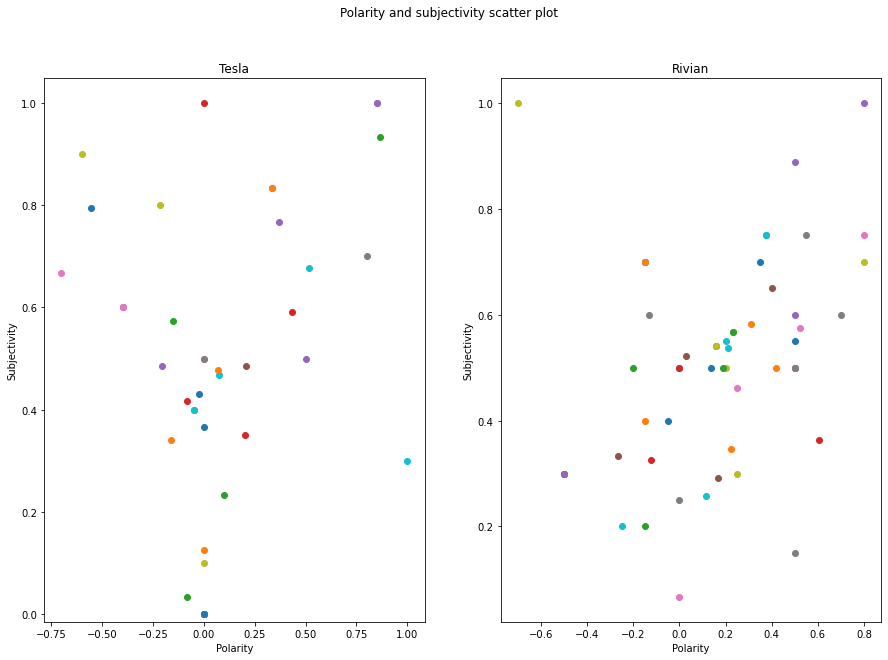

In [97]:
#Plotting both graph with Matplotlib. 

plt.figure(figsize=(15,10))
plt.suptitle("Polarity and subjectivity scatter plot")
plt.subplot(1,2,1)
plt.title("Tesla")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(tesla)):
    plt.scatter(x=tesla["polarity"][i], y=tesla["subjectivity"][i])
plt.subplot(1,2,2)
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(rivian)):
    plt.scatter(x=rivian["polarity"][i], y=rivian["subjectivity"][i])
plt.title("Rivian")
plt.show()

#Plotting both graph with Plotly. 

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=tesla["polarity"], y=tesla["subjectivity"], mode="markers", name="Tesla"),
    row=1, col=2)
fig.add_trace(
    go.Scatter(x=rivian["polarity"], y=rivian["subjectivity"], mode="markers", name="Rivian"),
    row=1, col=1)
fig.update_xaxes(title_text="Polarity")
fig.update_yaxes(title_text="Subjectivity")
fig.update_layout(height=800, width=1000, title_text="Polarity and subjectivity scatter plot")
fig.show()


### Counting the most used words by sentiment. 

In [98]:
# Joining and preprocessing all tweets based on sentiment.
tesla_preprocess_positive = preprocess_text("".join(tesla["tweets"][tesla["sentiment"] == "positive"]), custom_stopwords)
tesla_preprocess_negative = preprocess_text("".join(tesla["tweets"][tesla["sentiment"] == "negative"]), custom_stopwords)

rivian_preprocess_positive = preprocess_text("".join(rivian["tweets"][rivian["sentiment"] == "positive"]), custom_stopwords)
rivian_preprocess_negative = preprocess_text("".join(rivian["tweets"][rivian["sentiment"] == "negative"]), custom_stopwords)

#Counting the words of each sentiment. 
tesla_bow_positive = Counter(tesla_preprocess_positive)
tesla_bow_negative = Counter(tesla_preprocess_negative)

rivian_bow_positive = Counter(rivian_preprocess_positive)
rivian_bow_negative = Counter(rivian_preprocess_negative)

# Printing the most common words by sentiment. 
print("\nThen most frequent positive words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla_positive = tesla_bow_positive.most_common(10)
print(most_common_tesla_positive)

print("\nThen most frequent negative words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla_negative = tesla_bow_negative.most_common(10)
print(most_common_tesla_negative)

print("\nTen most frequent positive words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian_positive = rivian_bow_positive.most_common(10)
print(most_common_rivian_positive)

print("\nTen most frequent negative words and number of occurrences for Rivian according to Bag-of-Words:")
most_common_rivian_negative = rivian_bow_negative.most_common(10)
print(most_common_rivian_negative)


Then most frequent positive words and number of occurrences for Tesla according to Bag-of-Words:
[('2', 7), ('gt', 7), ('stock', 6), ('5', 6), ('3', 6), ('4', 6), ('split', 4), ('drone', 4), ('elonmusk', 4), ('1', 4)]

Then most frequent negative words and number of occurrences for Tesla according to Bag-of-Words:
[('people', 4), ('number', 4), ('get', 3), ('money', 3), ('delivery', 3), ('omillionaires', 3), ('really', 3), ('short', 3), ('gap', 3), ('call', 2)]

Ten most frequent positive words and number of occurrences for Rivian according to Bag-of-Words:
[('lcid', 10), ('get', 9), ('alert', 9), ('top', 8), ('pay', 7), ('gt', 7), ('f', 6), ('stock', 6), ('time', 6), ('day', 6)]

Ten most frequent negative words and number of occurrences for Rivian according to Bag-of-Words:
[('ape', 7), ('amc', 6), ('spy', 6), ('10', 5), ('9', 5), ('nfts', 5), ('fail', 5), ('gme', 5), ('utility', 5), ('nio', 5)]


### 2-Grams and 3-Grams are the combinations of two or three words used on twitter.

In [99]:
# Bigrams
bigrams_tesla = ngrams(tesla_preprocess, 2)
bigrams_tesla_count = Counter(bigrams_tesla)

print("Five most frequent word sequences and the number of occurrences in Tesla according to Bigrams:")
print(bigrams_tesla_count.most_common(5))

bigrams_rivian = ngrams(rivian_preprocess, 2)
bigrams_rivian_count = Counter(bigrams_rivian)

print("Five most frequent word sequences and the number of occurrences in Rivian according to Bigrams:")
print(bigrams_rivian_count.most_common(5))

#Threegram
threegram_tesla = ngrams(tesla_preprocess, 3)
threegrams_tesla_count = Counter(threegram_tesla)

print("Five most frequent word sequences and the number of occurrences in Tesla according to threegrams:")
print(threegrams_tesla_count.most_common(5))

threegrams_rivian = ngrams(rivian_preprocess, 3)
threegrams_rivian_count = Counter(threegrams_rivian)

print("Five most frequent word sequences and the number of occurrences in Rivian according to threegrams:")
print(threegrams_rivian_count.most_common(5))

Five most frequent word sequences and the number of occurrences in Tesla according to Bigrams:
[(('stock', 'split'), 3), (('delivery', 'number'), 3), (('get', 'ta'), 2), (('aave', 'etc'), 2), (('etc', 'ada'), 2)]
Five most frequent word sequences and the number of occurrences in Rivian according to Bigrams:
[(('crowd', 'source'), 5), (('source', 'alert'), 5), (('alert', 'rank'), 5), (('rank', 'system'), 5), (('system', 'get'), 5)]
Five most frequent word sequences and the number of occurrences in Tesla according to threegrams:
[(('aave', 'etc', 'ada'), 2), (('etc', 'ada', 'matic'), 2), (('ada', 'matic', 'xtz'), 2), (('matic', 'xtz', 'mana'), 2), (('xtz', 'mana', 'eth'), 2)]
Five most frequent word sequences and the number of occurrences in Rivian according to threegrams:
[(('crowd', 'source', 'alert'), 5), (('source', 'alert', 'rank'), 5), (('alert', 'rank', 'system'), 5), (('rank', 'system', 'get'), 5), (('system', 'get', 'pay'), 5)]


### 2 grams based on sentiments. 

In [100]:


# Positive Bigrams
bigrams_positive_tesla = ngrams(tesla_preprocess_positive, 2)
bigrams_positive_tesla_count = Counter(bigrams_positive_tesla)

print("Five most frequent positive word sequences in Tesla and the number of occurrences according to Bigrams:")
print(bigrams_positive_tesla_count.most_common(5))

# Negative Bigrams
bigrams_negative_tesla = ngrams(tesla_preprocess_negative, 2)
bigrams_negative_tesla_count = Counter(bigrams_negative_tesla)

print("Five most frequent negative word sequences in Tesla and the number of occurrences according to Bigrams:")
print(bigrams_negative_tesla_count .most_common(5))

# Positive Bigrams
bigrams_positive_rivian = ngrams(rivian_preprocess_positive, 2)
bigrams_positive_rivian_count = Counter(bigrams_positive_rivian)

print("Five most frequent positive word sequences in Rivian and the number of occurrences according to Bigrams:")
print(bigrams_positive_rivian_count.most_common(5))

# Negative Bigrams
bigrams_negative_rivian = ngrams(rivian_preprocess_negative, 2)
bigrams_negative_rivian_count = Counter(bigrams_negative_rivian)

print("Five most frequent negative word sequences in Rivian and the number of occurrences according to Bigrams:")
print(bigrams_negative_rivian_count.most_common(5))

Five most frequent positive word sequences in Tesla and the number of occurrences according to Bigrams:
[(('stock', 'split'), 2), (('aave', 'etc'), 2), (('etc', 'ada'), 2), (('ada', 'matic'), 2), (('matic', 'xtz'), 2)]
Five most frequent negative word sequences in Tesla and the number of occurrences according to Bigrams:
[(('delivery', 'number'), 3), (('5', 'pullback'), 2), (('production', 'delivery'), 2), (('feloniousmusk', 'wyatts_torch'), 1), (('wyatts_torch', 'keubiko'), 1)]
Five most frequent positive word sequences in Rivian and the number of occurrences according to Bigrams:
[(('crowd', 'source'), 5), (('source', 'alert'), 5), (('alert', 'rank'), 5), (('rank', 'system'), 5), (('system', 'get'), 5)]
Five most frequent negative word sequences in Rivian and the number of occurrences according to Bigrams:
[(('amc', 'ape'), 4), (('spy', 'gme'), 4), (('apecoin', 'ape'), 3), (('ukraine', 'ceoadam'), 3), (('ape', 'v'), 3)]


### 3 grams based on sentiments. 

In [101]:
# Positive Threegrams
threegrams__positive_tesla = ngrams(tesla_preprocess_positive, 3)
threegrams_positive_tesla_count = Counter(threegrams__positive_tesla)

print("Five most frequent positive word sequences in Tesla and the number of occurrences according to Threegram:")
print(threegrams_positive_tesla_count.most_common(5))

# Negative Threegrams
threegrams_negative_tesla = ngrams(tesla_preprocess_negative, 3)
threegrams_negative_tesla_count = Counter(threegrams_negative_tesla)

print("Five most frequent negative word sequences in Tesla and the number of occurrences according to Threegram:")
print(threegrams_negative_tesla_count.most_common(5))

# Positive Threegrams
threegrams_positive_rivian = ngrams(rivian_preprocess_positive, 3)
threegrams_positive_rivian_count = Counter(threegrams_positive_rivian)

print("Five most frequent positive word sequences in Rivian and the number of occurrences according to Threegram:")
print(threegrams_positive_rivian_count.most_common(5))

# Negative Threegrams
threegrams_negative_rivian = ngrams(rivian_preprocess_negative, 3)
threegrams_negative_rivian_count = Counter(threegrams_negative_rivian)

print("Five most frequent negative word sequences in Rivian and the number of occurrences according to Threegram:")
print(threegrams_negative_rivian_count.most_common(5))

Five most frequent positive word sequences in Tesla and the number of occurrences according to Threegram:
[(('aave', 'etc', 'ada'), 2), (('etc', 'ada', 'matic'), 2), (('ada', 'matic', 'xtz'), 2), (('matic', 'xtz', 'mana'), 2), (('xtz', 'mana', 'eth'), 2)]
Five most frequent negative word sequences in Tesla and the number of occurrences according to Threegram:
[(('production', 'delivery', 'number'), 2), (('feloniousmusk', 'wyatts_torch', 'keubiko'), 1), (('wyatts_torch', 'keubiko', 'one'), 1), (('keubiko', 'one', 'call'), 1), (('one', 'call', 'normal'), 1)]
Five most frequent positive word sequences in Rivian and the number of occurrences according to Threegram:
[(('crowd', 'source', 'alert'), 5), (('source', 'alert', 'rank'), 5), (('alert', 'rank', 'system'), 5), (('rank', 'system', 'get'), 5), (('system', 'get', 'pay'), 5)]
Five most frequent negative word sequences in Rivian and the number of occurrences according to Threegram:
[(('amc', 'ape', 'v'), 3), (('ape', 'v', 'citsecurities'

### Building a new dataframe for network explorations. 

In [102]:

bigram_df_tesla = pd.DataFrame(bigrams_tesla_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df_rivian = pd.DataFrame(bigrams_rivian_count.most_common(20),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
t = bigram_df_tesla.set_index('bigram').T.to_dict('records')
r = bigram_df_rivian.set_index('bigram').T.to_dict('records')


### Network Analysis

In [103]:
# Create network plot Tesla
Gt = nx.Graph()

# Create connections between nodes
for k, v in t[0].items():
    Gt.add_edge(k[0], k[1], weight=(v * 10))

Gt2 = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
Gt2.from_nx(Gt)
neighbor_map_t = Gt2.get_adj_list()
for node in Gt2.nodes:
    node["value"] = len(neighbor_map_t[node["id"]])  
    
Gt2.show("network_map_tesla.html")

# Create network plot Rivian
Gr = nx.Graph()

# Create connections between nodes
for k, v in r[0].items():
    Gr.add_edge(k[0], k[1], weight=(v * 10))

Gr2 = Network(height='750px', width='100%', bgcolor='#222222', font_color='white')
Gr2.from_nx(Gr)
neighbor_map_r = Gr2.get_adj_list()
for node in Gr2.nodes:
    node["value"] = len(neighbor_map_r[node["id"]])
    
Gr2.show("network_map_rivian.html")